# A Way Too In Depth Analysis Of Shake Of The Day

One day last summer I was with my dad at his friend's place and my dad's friend takes out a box full of dollar bills and asks my dad if he wants to pay a dollar to play a game for a chance to win half the money in the box.

The game is simple and goes like this.

    1. Choose a number to be your target.
    2. You have three rolls to get all 5 dice to land on your target value

Of course, since I was the math geek there, I was asked what the odds are of winning this game. After a bit of thinking I came up with the following equation. $$\sum_{i=0}^{5} \sum_{j=0}^{5-i} {5 \choose i} * (1/6)^i * (5/6)^{5-i} * {{5-i} \choose j} * (1/6)^j * (1/6)^{5-i-j} * (1/6)^{5-i-j}$$

So what the hell does that mean? To explain, first we will dive into the binomial distribution. The binomial distribution answers the following question: If I do the same thing n times (say flip a coin), and the probability of success each time is constant (for flipping a coin say success means it lands head, which would be probability 1/2), what is the probability of having k successes? The answer is as follows:

P(k successes in n trials with success probability p) = $ { n \choose k} * p^k * (1-p)^{n-k}$

Right away we can see the similarities with our original formula. Here the term $p^k * (1-p)^{n-k}$ is the probability of a particular way to ger k successes, while the term $ n \choose k $ is counting how many ways there are to get k successes out of n total. To illustrate, imagine you roll 3 dice and count a success as a dice landing on 6. In this case, since a dice has 6 equally likely sides, the probability of a particular die landing on 6 is simply 1/6, and the probability of failure, or that the die does not land on 6 is 1-(1/6) = (5/6). Suppose you want to know how likely it is for two of the three dice to land on 6. Let's look at one way to do so, suppose you label dice 1, 2 and 3. One way is for die 1 and 2 to land 6, and dice 3 to land on something else. What is the probability of this? Well since the probability of a dice landing on 6 is (1/6), the probability of 6, 6, not 6 is $$ {1/6} * {1/6} * {5/6} $$ But wait, the dice could also land 6, not 6, 6 or not 6, 6, 6, is there a way to count all the possible ways? Yes! and it is exactly $ n \choose k$, (pronounced n choose k) which is equal to $ {n!}/(k!*(n-k)!) $ 

So now back to the original problem. In our original equation, we are adding together all possible ways to get 5 successes in three rolls, such as 0 successes on the first, 0 on the second and 5 on the third. Or 1, 1, 3 or 2, 1, 2, etc. The variable i represents how many successes we have in our first roll, which can be any value between 0 (no die land on our target) to 5 (all of them do). The second variable j represents successes on our second throw, which can range from 0 to 5-i (since we wont throw dice that already have landed on our target, if i dice land on our target on our first throw, we will only throw 5-i the second time). So we multiply together the probability of i successes in 5 throws, given by the binomial described earlier, the probability of j successes in 5-i throws, also given by a binomial, and finally the 3rd throw we must have all 5-i-j remaining dice land on our target, which happens with probability $ (1/6)^{5-i-j} $

To actually compute this value, we can run the following python script, which simply does exactly what the equation describes.

In [1]:
import scipy.misc

# Simple binomial calculator. Returns the probability of k successes
# in n trials if the probability of success each trial is p.
def binomial(n, k, p):
    num_ways = scipy.misc.comb(n, k)  #Computes n choose k
    return num_ways * (p**k) * ((1-p)**(n-k))

probability = 0
for i in range(6): #Loop from 0 to 5
    for j in range(6-i): #Loop from 0 to 5-i
        probability += binomial(5, i, 1/6) * binomial(5-i, j, 1/6) * (1/6)**(5-i-j)
print(probability)

0.0132720560114


And we see that the probability is ~1.3%. As a reality check to make sure our answer is correct, we can try simulating this game using random numbers, and counting how often we win. The code below does that.

In [3]:
# Sanity check for correctness of probability.
# Runs a simulation num_trials number of times and reports the fraction
# of successes. By law of large numbers this fraction should get arbitrarily
# close to 0 as num_trials increases.
import random
def prob_sim(num_dice, num_trials, num_rolls):
    got = 0
    if num_dice == 0:
        return 1
    for num in range(num_trials):
        left_to_get = num_dice
        target = random.randint(1, 6)
        for j in range(num_rolls):
            for i in range(left_to_get):
                hit = random.randint(1, 6)
                if hit == target:
                    left_to_get -= 1
        if left_to_get == 0:
            got += 1
    return (got/num_trials)

print(prob_sim(5, 1000000, 3))

0.013354


Running the simulation for 1,000,000 iterations gives us a probability of ~1.33%, very close to our calculated probability of ~1.32%. So our method if probably correct.

# Going Beyond

The obvious next question is, what if we have more dice? or more rolls? The first case is easy, if we have more (or less) than 5 dice, we can simply swap the 5 out in our original equation for however many dice we have. The second is a bit more tricky, the number of rolls is reflected in the number of sums in our original equation (and the number of loops in our code), and it's tricky to write an equation with a variable number of loops. Fortunately, we can use recursion instead!

Simply, a function is recursive if it calls itself during execution, it avoids an infinite loop of calling itself by only calling itself on simpler versions of the problem it is trying to solve. We call these subproblems. Eventually, the subproblems all reduce down to some number of base cases, which have simple solutions. These solutions are then fed 'up' the chain until the original problem is solved. Let's see how we can use this idea to solve our problem.

Lets define subproblem shake(i, j) = probability of winning given there are i dice that still need to land on the target, and j rolls to do so. This leads to two simple base cases

    1) If i = 0, then no dice still need to land on our target, which means all dice already have. Therefore we have already won and probability of winning = 1
    
    2) if i > 0 and j = 1, we have one roll left to get all i dice to land on our target, this probability is simply given by the binomial distribution we gave earlier
    
Now we have base cases, but how do we move from complex cases to our base cases. Formally, what is our recurrence relation. Suppose we are at subproblem shake(i, j). Notice that we can roll anywhere from 0 to i successes this roll. Suppose we roll k dice onto our target value, what is the chance of winning now? Well it is just shake(i-k, j-1)! Since we can roll any number from 0 to i successes, the value of shake(i, j) is simply the sum over all the possible numbers of successes we can get this roll, times the probability of winning that way. Formally, shake(i, j) = $$\sum_{k=0}^{i} binomial(i, j, 1/6) * shake(i-k, j-1) $$  where binomial(i, k, 1/6) is the chance of rolling k successes given i dice, and shake(i-k, j-1) is the chance of winning once we have. This leads to the following function.

In [4]:
def shake_Of_The_Day(num_dice, num_rolls):
	if num_dice <= 0:
		return 1
	elif num_rolls == 1:
		return binomial(num_dice, num_dice, 1/6)

	currentProb = 0
	for i in range(num_dice + 1):
		currentProb += binomial(num_dice, i, 1/6) * shake_Of_The_Day(num_dice - i, num_rolls - 1)

	return currentProb

As a sanity check we can computer shake_Of_The_Day(5, 3) and compare it to what we computed in our original problem.

In [5]:
print(shake_Of_The_Day(5, 3))

0.0132720560114


And it's exactly the same. Yay! Now we can compute the probabilities of other combinations.

In [6]:
print('Probability of success given 5 dice and 4 rolls = ', shake_Of_The_Day(5, 4))
print('Probability of success given 5 dice and 5 rolls = ', shake_Of_The_Day(5, 5))
print('Probability of success given 5 dice and 6 rolls = ', shake_Of_The_Day(5, 6))
print('Probability of success given 4 dice and 3 rolls = ', shake_Of_The_Day(4, 3))
print('Probability of success given 3 dice and 3 rolls = ', shake_Of_The_Day(3, 3))

Probability of success given 5 dice and 4 rolls =  0.0372038250263
Probability of success given 5 dice and 5 rolls =  0.07655092414
Probability of success given 5 dice and 6 rolls =  0.130149152687
Probability of success given 4 dice and 3 rolls =  0.0315029021808
Probability of success given 3 dice and 3 rolls =  0.0747761194622


As you would expect, as you increase the number of dice your chance of winning decreases, and as you increase the number of rolls, your chance of winning increases. Unfortunately, our function is too slow to plot values with too many dice or rolls, which brings us to our next point.

# A Note About Efficiency

Our recursive algorithm for this problem is slow. Reaaallly slow. If we want to plot this function for larger inputs we are going to have to figure something better out. First let's examine how bad our algorithm is and why.

What we're going to do here is called asymptotic analysis, which is a fancy way of saying we want to see how many operations it takes for our algorithm to find the answer, and spevifically we are interested with how that number grows as we increase our input variables. In this kind of analysis we don't care about exact numbers but instead are trying to get an idea of the general behavior.

Lets define:

    1) num_dice = number of dice left
    2) num_rolls = number of rolls left.

So since our algorithm is recursive, the first question is, at any particular instance, how many times does the algorithm call itself? Well looking at the algorithm we see that it calls itself once for each possible number of rolls from 0 to the number of dice left which is num_dice. So in the worst case, each instance of shake_Of_The_Day calls itself num_dice number of times. Each of these subproblems, however can also call shake_Of_The_Day up to num_dice number of times, and those instances can call more subproblems, etc etc. So how many layers are there? That is how many times can a subproblem be called before we reach a base case? Simply since we have a base case at num_rolls = 1, in the worst case it will take roughly num_rolls layers to reach the bottom.

Therefore, each subproblem calls up to num_rolls additional subproblems, which each call up to num_rolls subproblems, up to num_dice number of times. This means that the total number of subproblems is ~ (num_dice * num_dice ...*num_dice) num_rolls number of times, or simply $$ (numdice)^{numrolls} $$

That's bad. To illustrate, if we compute our original problem of (5, 3) we get ~125 subproblems. Not bad. However suppose we want to increase this to just (7, 7) then we get ~823543 subproblems, increase it a little more to (9, 9) and we get all the way to ~387420489 subproblems! Clearly this number will get out of control very quickly. 

So WHY is our algorithm so bad? The reason is redundancy. Suppose we are solving our problem for num_dice = 5, num_rolls = 5

Imagine the following two scenarios.

    1)First roll we get 0 successes
    2)Second roll we get 2 successes

and 

    1)First roll yields 1 success
    2)Second roll yields 1 success
    
Clearly both of these scenarios lead to the same subproblem, that is num_dice = 3 and num_rolls = 3, but our algorithm has no way to take advantage of this fact, and ends up recomputing these values repeatedly. As our inputs increase, the amount of redundancy increases and becomes more punishing, leading to exponentially increasing runtimes. 

Let's devise an algorithm that removes this redundancy to speed up our runtime. This general method is called dynammic programming. 

As before, we define shake(i, j) to be subproblem with i dice and j rolls left. We note that the value of problem (i, j) is dependent solely on the values of subproblems (i*, j-1). That is, we can write tbe solution to a problem solely as a function of subproblems where the number of rolls is one less. This is the key. Because of this, if we start solving problems where number of rolls is 1, then move to subproblems where number of rolls is 2, etc, we can solve our original problem without ever having to solve the same subproblem more than once!!

So how do we do this? well first we'll create an 2-dimensional array, call it probabilities. We will define probabilities[i, j] = probability of winning given i rolls, j dice. We can then simply fill this array in the order described above, and simply use values already in our table instead of recomputing the value of subproblems. The resulting algorithm is as follows.

In [7]:
import numpy as np
def dynammic_shake(num_dice, num_rolls):
	probs = np.empty((num_rolls + 1, num_dice + 1))
	for i in range(num_rolls + 1):
		for j in range(num_dice + 1):
			if j == 0:
				probs[i][j] = 1
				continue
			elif j >= 1 and i == 0:
				probs[i][j] = 0
			elif i == 1 and j >= 1:
				probs[i][j] = binomial(j, j, 1/6)
			else:
				probs[i][j] = sum([probs[i-1][k] * binomial(j, j - k, 1/6) for k in range(0, j + 1)])
	return probs

print(dynammic_shake(5, 3)[3][5])

0.0132720560114


Again, we recompute our original value as a sanity check, and see that it is exactly the same as before. Success!

But what about the problem of speed, is this method really any better than our original? Let's look at the same type of asymptotic analysis we did the first time. 

In this method, we have two loops, one loops from 0 to num_rolls and one from 0 to num_dice, which means the inner loop is executed (num_rolls * num_dice) times. The inner loop, in the worst case when we are not in a base case, loops from 0 to j+1. In the worst case this is looping from 0 to ~num_dice. Putting it all together, we get that this algorithm takes roughly

num_rolls * num_dice * num_dice operations to complete, or num_rolls * num_dice^2. This is wayyyyy better than our previous time of $ (numdice)^{numrolls} $

For example problem (7, 7) only takes ~343 operations instead of the ~823543 we had before, (9, 9) is 729 compared to ~387420489!

This is all great in theory, but how well does this translate into a real-world increase in speed? The following script runs both algorithms for inputs ranging from (3, 3) to (14, 14) and then prints out how many times longer our original algorithm takes compared to our new dynammic programming algorithm.

In [16]:
import time
for i in range(12):
    start = time.time()
    dynammic_shake(i+3, i+3)
    end = time.time()

    start2 = time.time()
    shake_Of_The_Day(i+3, i+3)
    end2 = time.time()
    print(i+3,(end2-start2)/(end-start))

3 0.0
4 1.0052656773575874
5 2.498691410896978
6 5.98811410459588
7 13.0
8 34.144411944765665
9 99.81598306430273
10 286.56037053234206
11 824.6843718383622
12 2521.1908151604607
13 7892.942614989049
14 22982.704621200097


Wow. Even though both algorithms perform virtually the same when the input is small, our new algorithm quickly soars ahead in speed, up to an almost 23,000x increase at only (14, 14)!!

In addition, in the case where you are plotting values, our algorithm is even better, since you can return the entire computed array, so computing the solution to problem (i, j) also returns the solutions to all subproblems. Cool!

So let's use this power to plot. The following plots the probability of winning for all problems up to (40, 40) and displays them in a 3d graph.

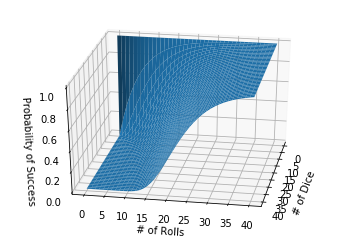

In [32]:
def plot(dice_end, rolls_end):
	x = np.arange(start=0, stop=rolls_end + 1)
	y = np.arange(start=0, stop=dice_end + 1)

	Z = dynammic_shake(dice_end, rolls_end)

	hf = plt.figure()
	ha = hf.add_subplot(111, projection='3d')

	X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
	ha.plot_surface(X, Y, Z)

	ha.set_xlabel('# of Dice')
	ha.set_ylabel('# of Rolls')
	ha.set_zlabel('Probability of Success')
	
	ha.view_init(30, 10)
	plt.show()
    
plot(40, 40)

As you would expect, probability increases with # of rolls and decreases with # of dice, although there are a few interesting things in this graph. 

    1) the relationship between probability and # of rolls is not linear. It seems like each additional dice you add is more valuable than the last dice up until a point (just by eyeballing it looks like #dice / 2), and then the value decreases.
    2) The more rolls you have, the less of an effect adding extra dice makes on your chance of winning. Eventually adding more dice doesn't seem to hurt your chances at  all.
    
We can plot this function for even more values, but as you can see below, everything past ~35-40 is pretty similar.

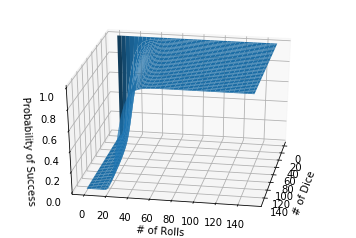

In [33]:
plot(150, 150)

Why is it shaped this way? Well if you think about it, to lose in this game at least 1 dice has to be rolled num_rolls times
and never land on the target, which is very unlikely as you have more rolls, since you roll all the dice yet to hit your
target each throw. Unfortunately, or perhaps fortunately, this revelation led me to a closed form solution to this problem
that makes all my work above basically a waste of time. Notice that

   1) The chance of any particular dice failing to land on your target after num_rolls rolls is $ (5/6)^{numrolls} $
   
   2) All dice are independent. 
   
This means we can solve this whole problem with one binomial, provided we choose the parameters correctly. We have,

   P(win) = binomial($ p = (5/6)^{numrolls}$, n = num_dice, k = 0)
   
Which simplifies to $$ (1 - (5/6)^{numrolls})^{numdice} $$ In code, this is pretty simple.

In [5]:
import math
def Constant_Shake(nDice, nRolls):
    return math.pow((1-math.pow(5/6, nRolls)), nDice)

print(Constant_Shake(5, 3))
print(Constant_Shake(5, 4))
print(Constant_Shake(5, 5))
print(Constant_Shake(5, 6))
print(Constant_Shake(4, 3))
print(Constant_Shake(3, 3))

0.013272056011374635
0.03720382502625021
0.07655092413995596
0.13014915268744046
0.031502902180845296
0.07477611946222622


And we see this is the same as the functions we wrote before. This one runs in basically constant time (taking a number to a power actually takes logarithmic time but we ignored this factor for our previous analysis so we will ignore it here), making it much better than even our improved version. 